# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

In this notebook, we will build a Convolutional Neural Network (CNN) which will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow.

We begin by importing the necessary modules:

In [5]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from keras.losses import categorical_crossentropy

# Table of contents

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

We first download the dataset. The dataset is already divided into a training set of 50000 images, and a test set of 10000.

In [6]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Checking the shape of images and targets:

In [7]:
print('images shape:', x_train[0].shape)
print('targets shape:', y_train[0].shape)

images shape: (32, 32, 3)
targets shape: (1,)


The 10 categories are :
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck
  
We will use the list of labels to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows:

In [8]:
labels = ['airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck']

We make sure to normalize images from [0,255] to be [0,1], to improve model training):

In [9]:
x_train = x_train/255
x_test  = x_test/255

We also convert the target arrays to one-hot encodings:

In [10]:
y_train = to_categorical(y_train, num_classes= 10, dtype='int')
y_test  = to_categorical(y_test, num_classes= 10, dtype='int')

The following cell allows us to visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  We create a figure using the first 8 images belonging to each category in the training data.

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


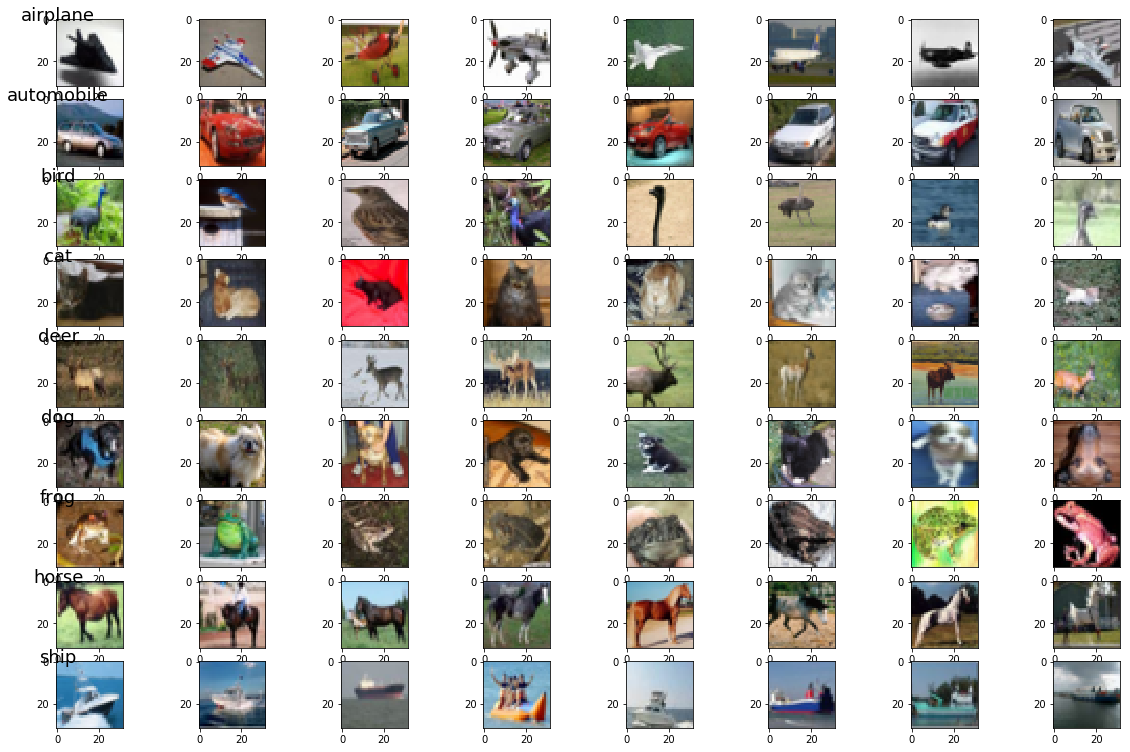

In [11]:
%matplotlib inline
(x_train_1, y_train_1), (x_test_1, y_test_1) = cifar10.load_data()
fig = plt.figure(figsize=(20, 16))

index=0
for i in range(9): #looop over classes
    fig.add_subplot(11, 8, index+1)
    plt.text(0.5, 0.5, labels[i],
             fontsize=18, ha='center')
    nb_img = 0
    j = -1
    
    while nb_img<8:
        j+=1
        if y_train_1[j]==i:
            index+=1
            fig.add_subplot(11, 8, index)
            plt.imshow(x_train[j])
            nb_img+=1
plt.show()   

The following code summarizes the previous operations. 

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


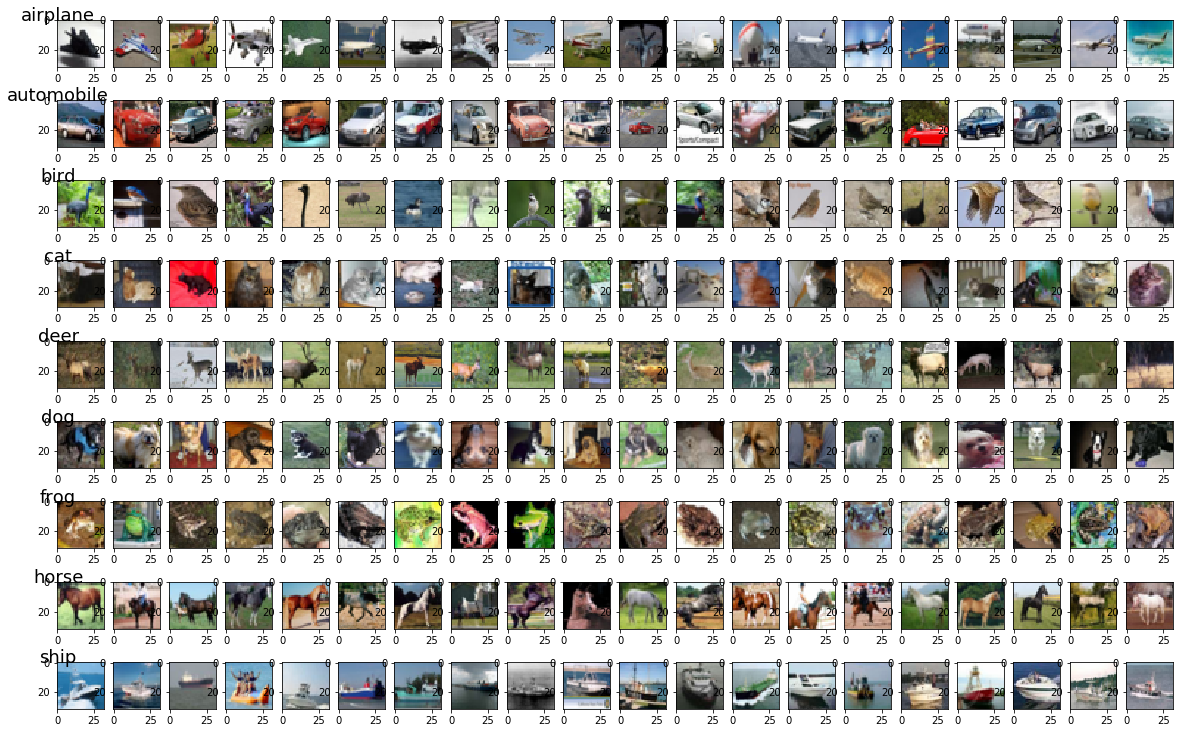

In [215]:
def load_cifar_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train/256
    x_test  = x_test/256
    y_train = to_categorical(y_train, num_classes= 10, dtype='int' )
    y_test  = to_categorical(y_test, num_classes= 10, dtype='int')
    labels = ['airplane',
                'automobile',
                'bird',
                'cat',
                'deer',
                'dog',
                'frog',
                'horse',
                'ship',
                'truck']
    return x_train, y_train, x_test, y_test, labels



def show_first_n_images_in_categories(n, labels_input, file_name=None):
    """Plots the first n images in each category from the image data."""
    (x_train_1, y_train_1), (x_test_1, y_test_1) = cifar10.load_data()
    labels = labels_input
    fig = plt.figure(figsize=(20, 16))

    index=0
    for i in range(9): #looop over classes
        fig.add_subplot(11, n, index+1)
        plt.text(0.5, 0.5, labels[i],
                 fontsize=18, ha='center')
        nb_img = 0
        j = -1

        while nb_img<n:
            j+=1
            if y_train_1[j]==i:
                index+=1
                fig.add_subplot(11, n, index)
                plt.imshow(x_train[j])
                nb_img+=1
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(20, labels)

<a id='first_model'></a>

# 2 - First naive model

before moving to CNNs, let's see how well a naive dense network performs on the dataset.

We created a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. We compiled the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
The introductory `Flatten` layer first converts the 3D (x, y, rgb) image data into 1D so they can be fed to the dense layers.

In [317]:
def dense_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape, name='flatten'))
    
    model.add(Dense(2048, activation='relu', name='dense_relu_1'))
    model.add(Dense(1024, activation='relu', name='dense_relu_2'))
    model.add(Dense(512, activation='relu', name='dense_relu_3'))
    model.add(Dense(256, activation='relu', name='dense_relu_4'))
    
    model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    return model

Dimension of each flattened image is $32*32*3 = 3072$

* Number of parameters in the 1st dense layer is $(3072+1)*2048 = 6293504$ (the +1 corresponds to the bias)
* Number of parameters in the 2nd dense layer is $(2048+1)*1024 = 2098176$
* Number of parameters in the 3rd dense layer is $(1024+1)*512 = 524800$
* Number of parameters in the 4th dense layer is $(512+1)*256 = 131328$
* Number of parameters in the output layer is $(256+1)*10 = 2570$

As a result, the total number of parameters is **9,050,378** (as proven by the following model summary).


In [57]:
input_shape = x_train[0].shape
num_classes = len(labels)
model = dense_model(input_shape, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense_relu_1 (Dense)         (None, 2048)              6293504   
_________________________________________________________________
dense_relu_2 (Dense)         (None, 1024)              2098176   
_________________________________________________________________
dense_relu_3 (Dense)         (None, 512)               524800    
_________________________________________________________________
dense_relu_4 (Dense)         (None, 256)               131328    
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
_________________________________________________________________


We train our model for 10 epochs, with a batch size of 32 (you may also use early stopping), and compute performance:

In [58]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1)
    return ret

dense_model = train_model(model, x_train, y_train)
model.save_weights(filepath='final_weight_dense.h5')

Epoch 1/10
50000/50000 [==============================] - 105s 2ms/step - loss: 1.8326 - acc: 0.3405
Epoch 2/10
50000/50000 [==============================] - 97s 2ms/step - loss: 1.6324 - acc: 0.4196
Epoch 3/10
50000/50000 [==============================] - 93s 2ms/step - loss: 1.5413 - acc: 0.4513
Epoch 4/10
50000/50000 [==============================] - 97s 2ms/step - loss: 1.4750 - acc: 0.4751
Epoch 5/10
50000/50000 [==============================] - 95s 2ms/step - loss: 1.4236 - acc: 0.4949
Epoch 6/10
50000/50000 [==============================] - 93s 2ms/step - loss: 1.3764 - acc: 0.5105
Epoch 7/10
50000/50000 [==============================] - 97s 2ms/step - loss: 1.3347 - acc: 0.5263
Epoch 8/10
50000/50000 [==============================] - 101s 2ms/step - loss: 1.2958 - acc: 0.5407
Epoch 9/10
50000/50000 [==============================] - 102s 2ms/step - loss: 1.2618 - acc: 0.5513
Epoch 10/10
50000/50000 [==============================] - 92s 2ms/step - loss: 1.2252 - acc: 0.5

In [59]:
performance = dense_model.model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', performance[0])
print('Test accuracy:', performance[1])
model.save(filepath='final_dense.h5')

Test loss: 1.4221648433685303
Test accuracy: 0.4976


The test accuracy is under 0.5... As shown in the next cells, the predictions are not so accurate:

In [194]:
ynew = model.predict(x_test)

<function matplotlib.pyplot.show>

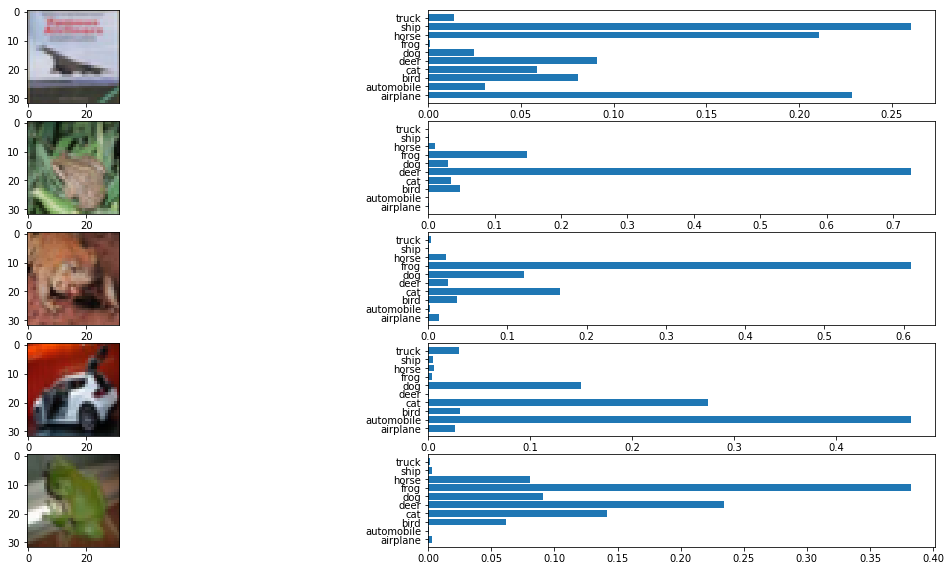

In [218]:
fig = plt.figure(figsize=(20, 16))

index=1
for i in range(3,8):
    fig.add_subplot(8, 2, index) # to plot the image
    plt.imshow(x_test[i])
    index+=1
    
    fig.add_subplot(8, 2, index) # to plot the corresponding barplot
    plt.barh(y = labels,width=ynew[i] )
    index+=1
    
plt.show

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allowed us to do drastically better on this dataset.

<a id='first_cnn'></a>
## 3.1 - Baseline CNN

The CNN architecture we used is as follows:
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [237]:
def cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Conv2D(64, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(output_dim = 10, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    
    return model

cnn_model_base = cnn_model(x_train.shape[1:], 10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`
  del sys.path[

Number of parameters:
- First Convolutional layer:  32x9x3+32 = 896
- Second Convolutional layer: (32 x 3 x 3 + 1) x 32 = 9248
- First Max Pooling: This layer is used to reduce the input image size. kernal_size = (2,2) used here. So input image 96 is reduced to half 48. And model learns nothing from this layer.
- Third Convolutional layer:  (3 x 3 x 32 + 1) x 64 = 18496
- Fourth Convolutional layer:  (3 x 3 x 64 + 1) x 64 = 36928
- First dense layer: 512 x (1600+1) = 819712
- Second Dense Layer: 10 x (512 + 1) = 5130

The total is the sum of all previous: 890,410

This is a lot less than the ≈9M of the dense model. This is due to the fact that convolutional layers aren't fully connceted (convolution instead of matrix product: in matrix product, all input and output units are connected, replacing the matrix product by a convolution restricts the connections). Connectivity is sparse vs dense, it involves a lot less parameters, improves memory and statistical efficiency.

In [238]:
cnn_model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1600)              0         
__________

In the next cells, we train the model with 10 epochs and batch size of 32, and we plot train and validation accuracy over each epoch:

In [239]:
def train_cnn(model, x, y, batch_size=32, epochs=10, file_name=None):
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.25)
    return ret

cnn = train_cnn(cnn_model_base, x_train, y_train)
cnn_model_base.save_weights(filepath='final_weight_cnn.h5')

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 129s 3ms/step - loss: 2.0251 - acc: 0.2571 - val_loss: 1.9205 - val_acc: 0.3130
Epoch 2/10
37500/37500 [==============================] - 113s 3ms/step - loss: 1.6790 - acc: 0.3944 - val_loss: 1.5766 - val_acc: 0.4298
Epoch 3/10
37500/37500 [==============================] - 114s 3ms/step - loss: 1.4757 - acc: 0.4691 - val_loss: 1.4046 - val_acc: 0.4934
Epoch 4/10
37500/37500 [==============================] - 113s 3ms/step - loss: 1.3413 - acc: 0.5221 - val_loss: 1.3147 - val_acc: 0.5333
Epoch 5/10
37500/37500 [==============================] - 113s 3ms/step - loss: 1.2347 - acc: 0.5636 - val_loss: 1.2207 - val_acc: 0.5673
Epoch 6/10
37500/37500 [==============================] - 394s 10ms/step - loss: 1.1409 - acc: 0.5971 - val_loss: 1.1511 - val_acc: 0.5997
Epoch 7/10
37500/37500 [==============================] - 937s 25ms/step - loss: 1.0598 - acc: 0.6254 - val_loss: 1.0911 

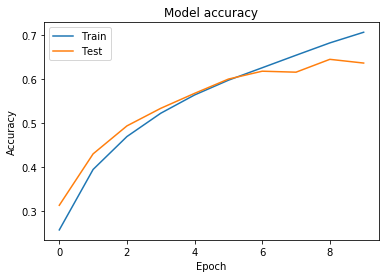

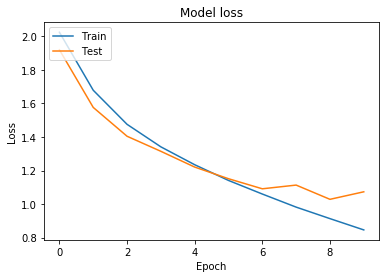

In [240]:
# Plot training & validation accuracy values per epoch
history = cnn
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# validation_split=0.25

We can see that validation accuracy improves (along with training accuracy) during the first 6 epochs. Than during the last 3 epochs, training accuracy keeps improving, but validation accuracy stagnates - this is due to overfitting (we will fix this in the next questions).

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

### Batch size

We first observed that **batch size** impacts the performance of our model.

Using the whole training dataset is not computationaly efficient. Using only 1 single sample for the gradient updates could decrease accuracy as the sample might be noisy (not a good representation of the whole data).

What we found in literature is that we usually choose a default size of 32 or 64:  

>"… [batch size] is typically chosen between 1 and a few hundreds, e.g. [batch size] = 32 is a good default value" — Practical recommendations for gradient-based training of deep architectures , 2012.  


>"The presented results confirm that using small batch sizes achieves the best training stability and generalization performance, for a given computational cost, across a wide range of experiments. In all cases the best results have been obtained with batch sizes m = 32 or smaller, often as small as m = 2 or m = 4." — Revisiting Small Batch Training for Deep Neural Networks , 2018.



In [244]:
# test with batch_size = 1
# only 1 epoch to go faster
cnn_model_base = cnn_model(x_train.shape[1:], 10)
cnn_model_batch1 = train_cnn(cnn_model_base, x_train, y_train, batch_size = 1, epochs=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`
  del sys.path[

Train on 37500 samples, validate on 12500 samples
Epoch 1/1
37500/37500 [==============================] - 354s 9ms/step - loss: 1.6718 - acc: 0.3893 - val_loss: 1.4573 - val_acc: 0.4922


In [245]:
# test with batch_size = 100
cnn_model_base = cnn_model(x_train.shape[1:], 10)
cnn_model_batch100 = train_cnn(cnn_model_base, x_train, y_train, batch_size = 100, epochs=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`
  del sys.path[

Train on 37500 samples, validate on 12500 samples
Epoch 1/1
37500/37500 [==============================] - 141s 4ms/step - loss: 2.2318 - acc: 0.1952 - val_loss: 2.1723 - val_acc: 0.2075


In [246]:
# test with batch_size = 1000
cnn_model_base = cnn_model(x_train.shape[1:], 10)
cnn_model_batch1000 = train_cnn(cnn_model_base, x_train, y_train, batch_size = 1000, epochs=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`
  del sys.path[

Train on 37500 samples, validate on 12500 samples
Epoch 1/1
37500/37500 [==============================] - 124s 3ms/step - loss: 2.3014 - acc: 0.0954 - val_loss: 2.2955 - val_acc: 0.1170


*Conclusions* : 

Training time: On our computer (MacBook Pro 2016)
- With batch_size = 32 training duration is around 2 minutes per epoch, which looks like a good performance compared to other values we tested.
- With batch_size = 100, training is a little longer, around 2,30 min/epoch. 
- With batch_size = 1000, it's also not better than batch_size = 32, with around 2 min/epoch. 
- With batch_size = 1, it's much longer, around 6 min/epoch.


Accuracy: 
After one epoch,
- With batch_size = 32 validation accuracy of 0.31.
- With batch_size = 100, validation accuracy of 0.21. 
- With batch_size = 1000, accuracy of 0.12. 
- With batch_size = 1, accuracy of 0.49. 

Which tends to shows (even it's only after 1 epoch) that smaller batch sizes achieve better generalization performance (i.e. accuracy on the validation dataset), at the expense of longer training time. **Batchsize 32 has a better batchsize/training time trade off.**

### Dropout

We noticed that the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  This phenomenon is *overfitting*, i.e. at some point the model describes our training data better and better but is less performant on generalization. 

We tried to reduce over fitting by adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.

In [229]:
#Dropout ration of 0.25
def cnn_model_dropout(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Conv2D(64, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(output_dim = 10, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    
    return model

cnn_dropout_model = cnn_model_dropout(x_train.shape[1:], 10)


def train_cnn(model, x, y, batch_size=32, epochs=10, file_name=None):
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.25)
    return ret

cnn_dropout = train_cnn(cnn_dropout_model, x_train, y_train)
cnn_dropout_model.save(filepath='final_cnn_dropout.h5')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 151s 4ms/step - loss: 1.9967 - acc: 0.2679 - val_loss: 1.8542 - val_acc: 0.3616
Epoch 2/10
37500/37500 [==============================] - 174s 5ms/step - loss: 1.6707 - acc: 0.3983 - val_loss: 1.6833 - val_acc: 0.4252
Epoch 3/10
37500/37500 [==============================] - 168s 4ms/step - loss: 1.5236 - acc: 0.4501 - val_loss: 1.5497 - val_acc: 0.4921
Epoch 4/10
37500/37500 [==============================] - 170s 5ms/step - loss: 1.4241 - acc: 0.4854 - val_loss: 1.4843 - val_acc: 0.5125
Epoch 5/10
37500/37500 [==============================] - 151s 4ms/step - loss: 1.3431 - acc: 0.5195 - val_loss: 1.3693 - val_acc: 0.5431
Epoch 6/10
37500/37500 [==============================] - 124s 3ms/step - loss: 1.2731 - acc: 0.5458 - val_loss: 1.3316 - val_acc: 0.5627
Epoch 7/10
37500/37500 [==============================] - 155s 4ms/step - loss: 1.2078 - acc: 0.5683 - val_loss: 1.2865 - 

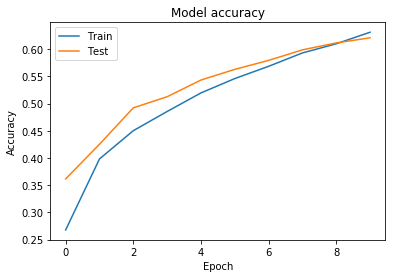

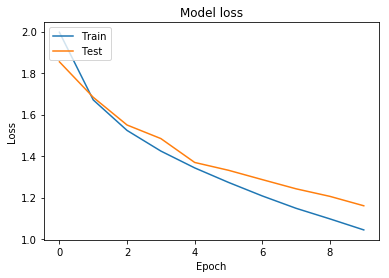

In [241]:
# Plot training & validation accuracy values
history = cnn_dropout
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# validation_split=0.25

We can see that simply adding dropout **doesn't improve the top accuracy we can reach** vs. previous model. But it **helps reduce overfitting** (in the previous model, validation acuracy started stagnating at epoch n°6, whereas now validation accuracy keeps increasing along with training accuracy during all epochs).

### Batch normalization

We added batch normalization layers before each dropout layer, in order to renormalize the outputs of each layer (not only at the start of the network).

In [232]:
def cnn_model_batch(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(Conv2D(64, 3, 3, input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(output_dim = 10, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    
    return model

cnn_batch_model = cnn_model_batch(x_train.shape[1:], 10)

def train_cnn(model, x, y, batch_size=32, epochs=10, file_name=None):
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1 , validation_split=0.25)
    return ret

cnn_batch = train_cnn(cnn_batch_model, x_train, y_train)
cnn_batch_model.save(filepath='final_weight_cnn_batch_model.h5')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the 

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 224s 6ms/step - loss: 1.8175 - acc: 0.3824 - val_loss: 2.0433 - val_acc: 0.3466
Epoch 2/10
37500/37500 [==============================] - 230s 6ms/step - loss: 1.3457 - acc: 0.5264 - val_loss: 1.8923 - val_acc: 0.3825
Epoch 3/10
37500/37500 [==============================] - 233s 6ms/step - loss: 1.1888 - acc: 0.5815 - val_loss: 1.7198 - val_acc: 0.4375
Epoch 4/10
37500/37500 [==============================] - 230s 6ms/step - loss: 1.0821 - acc: 0.6190 - val_loss: 1.3395 - val_acc: 0.5462
Epoch 5/10
37500/37500 [==============================] - 200s 5ms/step - loss: 1.0015 - acc: 0.6497 - val_loss: 1.1853 - val_acc: 0.5908
Epoch 6/10
37500/37500 [==============================] - 209s 6ms/step - loss: 0.9284 - acc: 0.6758 - val_loss: 1.7179 - val_acc: 0.4617
Epoch 7/10
37500/37500 [==============================] - 198s 5ms/step - loss: 0.8731 - acc: 0.6934 - val_loss: 1.1647 - 

Batch normalization before dropout significantly improves performance. But the validation accuracy score seems to highly depend on the number of epochs.

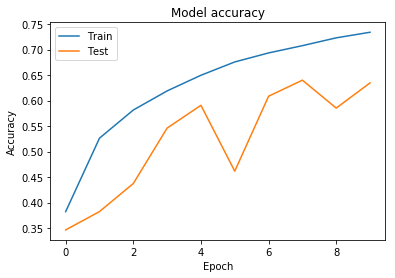

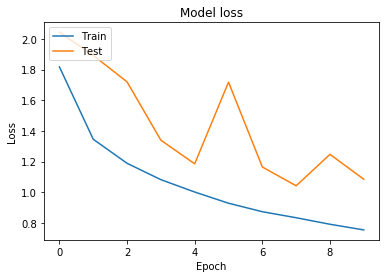

In [242]:
# Plot training & validation accuracy values per epoch
history = cnn_batch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Batch normalization before dropout significantly improves our maximal performance, be it on the training or on the validation dataset.

However we can see in the graphs that the validation accuracy score seems to highly depend on the number of epochs. **7 epochs seems to be the optimal number in our case**.

<a id='results'></a>

## 3.3 - Studying predictions

Let's display some of our predictions and compare with the previous dense network.

In [209]:
y_prob = cnn_batch_model.predict(x_test)

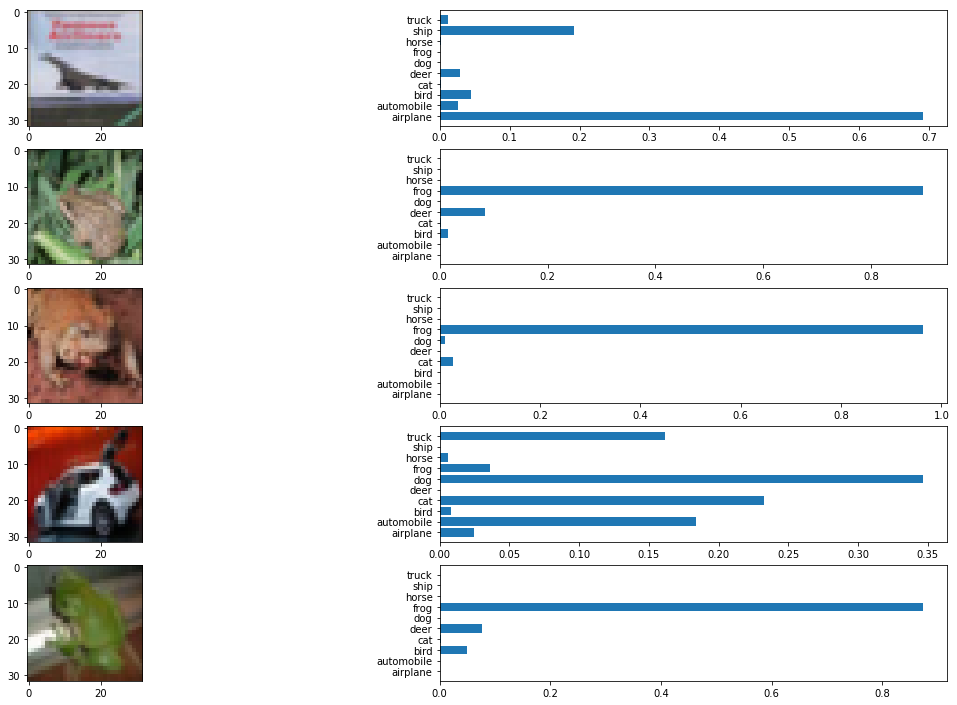

In [210]:
from scipy import stats
def predict(y_prob, x, labels, file_name=None):
    
    fig = plt.figure(figsize=(20, 20))
    index=1
    for i in range(3,8):
        fig.add_subplot(8, 2, index)
        plt.imshow(x_test[i])
        index+=1
        
        fig.add_subplot(8, 2, index)
        plt.barh(y = labels,width=y_prob[i] )
        index+=1
        
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

predict(y_prob, x_test, labels)

We also plotted a confusion matrix using the test dataset, in order to understand how well (or not) each category is being classified (i.e. more information than a simple accuracy measurement). The confusion matrix vizualization will also help us identify the categories that were the most mispredicted.

In [129]:
y_pred = cnn_batch_model.predict_classes(x_test)

          y_test      y_pred
0            cat         dog
1           ship        ship
2           ship        ship
3       airplane        ship
4           frog        frog
...          ...         ...
9995        ship         cat
9996         cat         dog
9997         dog         dog
9998  automobile  automobile
9999       horse       horse

[10000 rows x 2 columns]


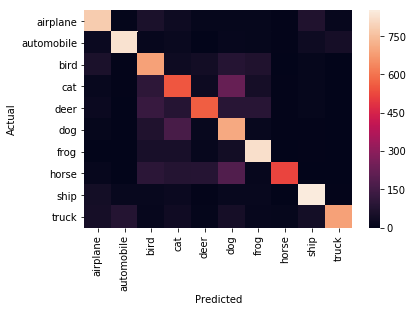

In [158]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_class_true(y):
    y_labeled = []
    for ind in y:
        i = np.where(ind == 1)
        y_labeled.append(labels[i[0][0]])
    return y_labeled

def get_class_pred(y):
    y_labeled = []
    for ind in y:
        y_labeled.append(labels[ind])
    return y_labeled

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    pred_true = pd.DataFrame({'y_test': get_class_true(y_true), 'y_pred': get_class_pred(y_pred)})
    print(pred_true)
    confusion = confusion_matrix(pred_true.y_test, pred_true.y_pred).ravel()
    confusion = pd.crosstab(pred_true['y_test'], pred_true['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion)
    
plot_confusion_matrix(y_test, y_pred, classes = labels)

We can see the true positive ratios in the diagonal of our heatmap (which is a readable representation of the confusion matrix). We observe that **'horse' is the less well predicted**. We can also see the **most common confusions: 'dog' is often mispredicted as 'cat' or 'horse', and 'cat' is often mispredicted as 'dog'**.

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Finally, we tried to adapt a pre-trained network (VGG16, trained on the ImageNet dataset) to our problem.

In [163]:
# Import pre-trained model

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=x_train.shape[1:])

58892288/58889256 [==============================] - 10s 0us/step


In [281]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

#### Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. We will run our data through this `conv_base` network and then add a densely-connected classifier on top (2 dense layers), which we will train from scratch on our data so that the new model finally becomes adapted to our problem.

In [308]:
features = conv_base.predict(x_test)

In [299]:
# define the full model

model_pretrained = Sequential()

model_pretrained.add(conv_base) # add the pre-trained conv_base
model_pretrained.add(Flatten()) # flatten output and add 2 final dense layers
model_pretrained.add(Dense(512, activation='relu'))
model_pretrained.add(Dense(output_dim = 10, activation='softmax'))

model_pretrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_21 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_62 (Dense)             (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`
  import sys


In [300]:
# freeze the pre-trained conv layers for training

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_pretrained.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_pretrained.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


In [304]:
# train the model on our data

model_pretrained.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])

history = model_pretrained.fit(x_train, y_train, batch_size=32,
      epochs=10,
      validation_split=0.25,
      verbose=1)

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 825s 22ms/step - loss: 1.6720 - acc: 0.4274 - val_loss: 1.5149 - val_acc: 0.4714
Epoch 2/10
37500/37500 [==============================] - 790s 21ms/step - loss: 1.4471 - acc: 0.5009 - val_loss: 1.4028 - val_acc: 0.5168
Epoch 3/10
37500/37500 [==============================] - 713s 19ms/step - loss: 1.3703 - acc: 0.5257 - val_loss: 1.3434 - val_acc: 0.5347
Epoch 4/10
37500/37500 [==============================] - 659s 18ms/step - loss: 1.3252 - acc: 0.5408 - val_loss: 1.3270 - val_acc: 0.5354
Epoch 5/10
37500/37500 [==============================] - 700s 19ms/step - loss: 1.2932 - acc: 0.5513 - val_loss: 1.2906 - val_acc: 0.5525
Epoch 6/10
37500/37500 [==============================] - 764s 20ms/step - loss: 1.2675 - acc: 0.5585 - val_loss: 1.2840 - val_acc: 0.5498
Epoch 7/10
37500/37500 [==============================] - 723s 19ms/step - loss: 1.2477 - acc: 0.5657 - val_loss: 1.

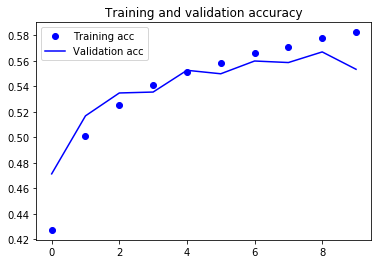

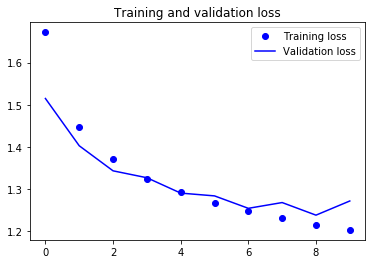

In [305]:
# plot performance

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Performance isn't significantly improved with the pre-trained model compared to our previous model. Maybe it is due to our pre-trained model choice (VGG16 maybe isn't the best one in our case?). We don't have time to try other models (this one already took +3h to train...), but with a good model choice and the method followed above, we should be able to improve performance compared to our in-house model.

#### Fine-tuning

To push performance even further, we could also fine-tune the last top layers of the conv_base. We did not do it here because of training time, but here is how and why we could have done it:

* Fine-tuning would consist in unfreezing a few of the top layers of the convolutional model base, so we can slightly re-adjust the more abstract representations and make them more relevant for our problem.
* We could fine-tune the entire convolutional base, but we'd rather just unfreeze the top layers - the reason is that the earlier layers encode more generic, reusable features, while layers higher up (the 2-3 top layers) encode more specialized features, which can be repurposed on our new problem.
* To train these layers we should use a very low learning rate, in order to limit the magnitude of the modifications we make (updates that are too large may harm the previous representations).
* Using a pre-trained model and fine-tuning it to our specific problem allows to reach stronger performance on a small dataset.